In [ ]:
# import libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from keras import models, layers, regularizers, wrappers
from keras.wrappers.scikit_learn import KerasClassifier
import datetime
from google.colab import files
import io

%matplotlib inline

In [ ]:
# importing dataset
df = pd.read_csv('Breast_cancer_data.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [ ]:
# a quick discription
df.info()
print('-'*50)
print(f'Data shape:{df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB
--------------------------------------------------
Data shape:(569, 6)


In [ ]:
# null values
df.isnull().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

In [ ]:
# get to know the features precisely
df.describe().round(2)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.00,569.00,569.00,569.00,569.00,569.00
mean,14.13,19.29,91.97,654.89,0.10,0.63
std,3.52,4.30,24.30,351.91,0.01,0.48
min,6.98,9.71,43.79,143.50,0.05,0.00
25%,11.70,16.17,75.17,420.30,0.09,0.00
50%,13.37,18.84,86.24,551.10,0.10,1.00
75%,15.78,21.80,104.10,782.70,0.11,1.00
max,28.11,39.28,188.50,2501.00,0.16,1.00


In [ ]:
# check for duplicate rows in the dataset
dup_row = df[df.duplicated()]
print("Duplicate Rows :")
print(dup_row )

Duplicate Rows :
Empty DataFrame
Columns: [mean_radius, mean_texture, mean_perimeter, mean_area, mean_smoothness, diagnosis]
Index: []


1    357
0    212
Name: diagnosis, dtype: int64


([<matplotlib.patches.Wedge at 0x7f05f6810a20>,
 [Text(-0.4286546999573329, 1.0130425204326268, 'Class 1'),
  Text(0.428654605109445, -1.013042560566172, 'Class 0')],
 [Text(-0.23381165452218156, 0.5525686475087055, '62.7%'),
  Text(0.23381160278696997, -0.55256866939973, '37.3%')])

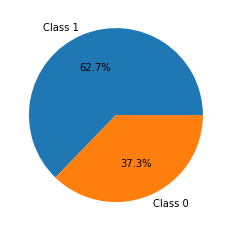

In [ ]:
# Understanding the response variable
print(df.diagnosis.value_counts())

Classes = ['Class 1', 'Class 0']
plt.pie(x=df.diagnosis.value_counts(), labels=Classes, autopct="%.1f%%")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, "Classes' Frequency")

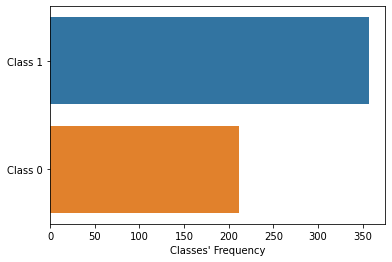

In [ ]:
sns.barplot(df.diagnosis.value_counts(), Classes)
plt.xlabel("Classes' Frequency")

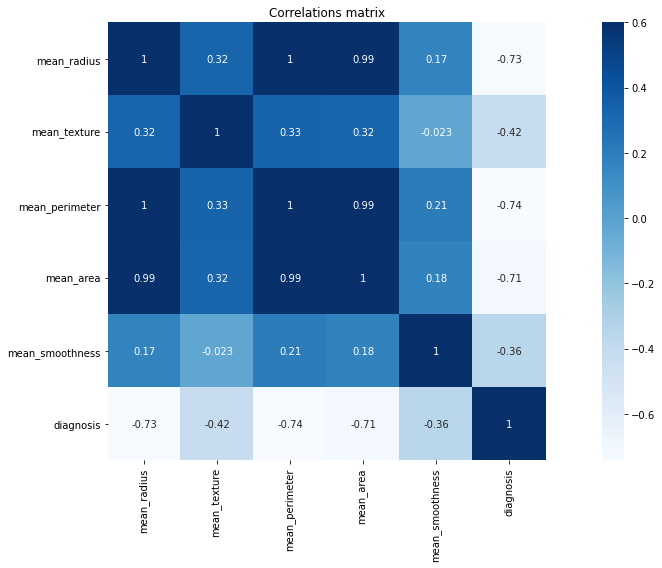

In [ ]:
# Feature Construction

# look at the relationships among the features in our dataset to find the most positive or negative correlated features.
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), vmax=0.6, square=True, annot=True, cmap='Blues')
plt.title('Correlations matrix')
plt.tight_layout()

In [ ]:
# As we can see from the correlations matrix, there is a linear relationship among "**area**", "**Permeter**", and "**radius**".
# In order to obtain additional features to better train our model, two additional, nonlinear geometry based features were constructed by correlated features: The fractal dimension and the compactness of the growths.

Text(153.125, 0.5, 'Compactness')

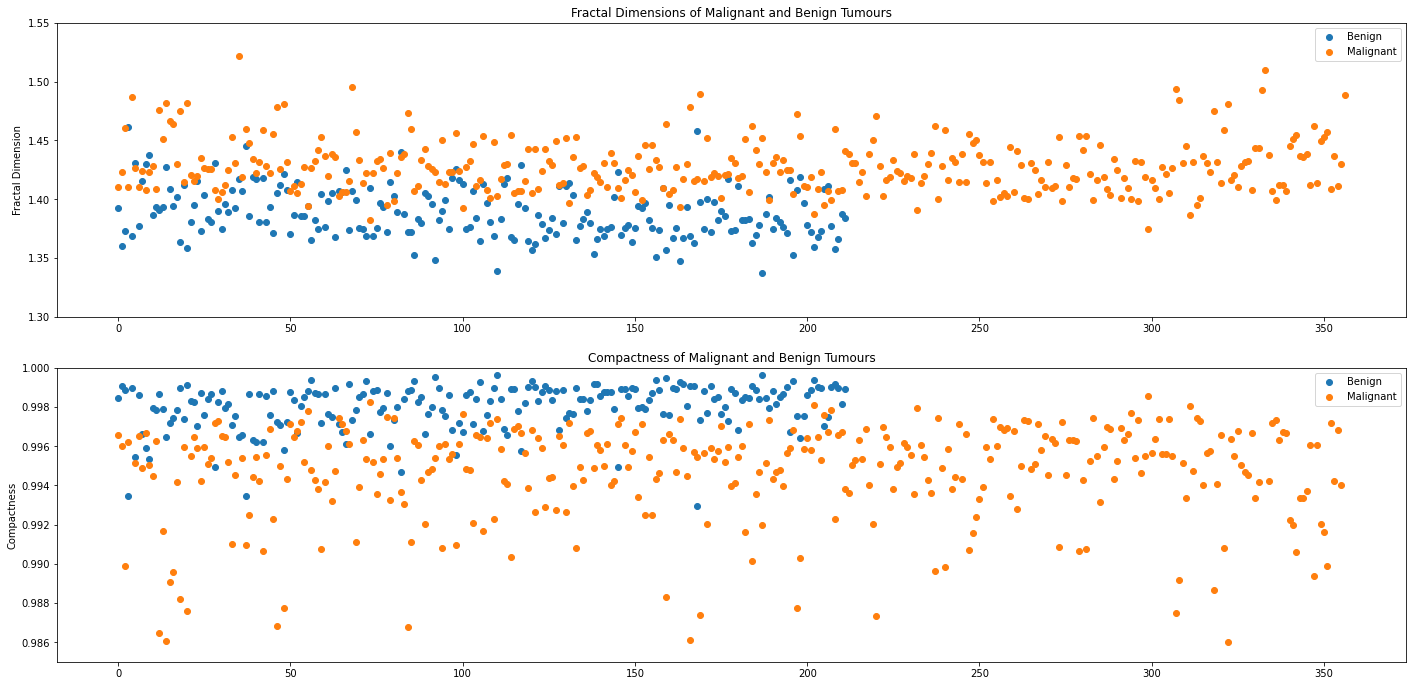

In [ ]:
# Compute new features
fractal_dimension = 2*np.log(df.mean_perimeter)/np.log(df.mean_area)
compactness = 1-(4*(np.pi*df.mean_perimeter)/(df.mean_area**2))

# Insert into a copy of the dataframe (to avoid erorrs with inserting in the future)
df2 = df.copy()
df2.insert(6,"fractal_dimension",fractal_dimension)
df2.insert(7,"compactness",compactness)

# Find output vriable value for each input of new feautres (for plotting)
benign_fractal = df2.loc[df['diagnosis'] == 0, 'fractal_dimension']
benign_compact = df2.loc[df['diagnosis'] == 0, 'compactness']
malignant_fractal = df2.loc[df['diagnosis'] == 1, 'fractal_dimension']
malignant_compact = df2.loc[df['diagnosis'] == 1, 'compactness']

# Create Plots of output variables and new features
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (20,10))
fig.tight_layout(pad=3.0)
ax1.scatter(range(len(benign_fractal)),benign_fractal, label = "Benign")
ax1.scatter(range(len(malignant_fractal)),malignant_fractal, label="Malignant")
ax1.set_ylim([1.3,1.55])
ax1.legend()
ax1.set_title("Fractal Dimensions of Malignant and Benign Tumours")
ax1.set_ylabel("Fractal Dimension")

ax2.scatter(range(len(benign_compact)),benign_compact, label = "Benign")
ax2.scatter(range(len(malignant_compact)),malignant_compact, label="Malignant")
ax2.set_ylim([0.985,1.00])
ax2.legend()
ax2.set_title("Compactness of Malignant and Benign Tumours")
ax2.set_ylabel("Compactness")

In [ ]:
# Data preprocessing

# Split data to train and test sets
# X and y
X = df2.drop('diagnosis', axis = 'columns')
y = df2.diagnosis

# Random state assures that folds are consistent across models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')

X_train shape: (398, 7)
X_test shape: (171, 7)


In [ ]:
# Feature Selection

# Logistic regression model as a base to use in CV approach
logreg = LogisticRegression(max_iter=1000)

#Full model using all predictor variables
cv_score=cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
cv_score1=cross_val_score(logreg, X_train, y_train, cv=5, scoring='average_precision')
print("Base Model accuracy:", cv_score.mean(), "and precision:", cv_score1.mean())


# Model without mean_radius
Xwithout_mean_radius = X_train.drop(['mean_radius'], axis='columns')

cv_score=cross_val_score(logreg, Xwithout_mean_radius, y_train, cv=5, scoring='accuracy')
cv_score1=cross_val_score(logreg, Xwithout_mean_radius, y_train, cv=5, scoring='average_precision')
print("Model without mean_radius accuracy:", cv_score.mean(), "and precision:", cv_score1.mean())

# Model without mean_texture
Xwithout_mean_texture = X_train.drop(['mean_texture'], axis='columns')

cv_score=cross_val_score(logreg, Xwithout_mean_texture, y_train, cv=5, scoring='accuracy')
cv_score1=cross_val_score(logreg, Xwithout_mean_texture, y_train, cv=5, scoring='average_precision')
print("Model without mean_texture accuracy:", cv_score.mean(), "and precision:", cv_score1.mean())

# Model without mean_perimeter
Xwithout_mean_perimeter = X_train.drop(['mean_perimeter'], axis='columns')

cv_score=cross_val_score(logreg, Xwithout_mean_perimeter, y_train, cv=5, scoring='accuracy')
cv_score1=cross_val_score(logreg, Xwithout_mean_perimeter, y_train, cv=5, scoring='average_precision')
print("Model without mean_perimeter accuracy:", cv_score.mean(), "and precision:", cv_score1.mean())

# Model without mean_area
Xwithout_mean_area = X_train.drop(['mean_area'], axis='columns')

cv_score=cross_val_score(logreg, Xwithout_mean_area, y_train, cv=5, scoring='accuracy')
cv_score1=cross_val_score(logreg, Xwithout_mean_area, y_train, cv=5, scoring='average_precision')
print("Model without mean_area accuracy:", cv_score.mean(), "and precision:", cv_score1.mean())

# Model without mean_smoothness
Xwithout_mean_smoothness = X_train.drop(['mean_smoothness'], axis='columns')

cv_score=cross_val_score(logreg, Xwithout_mean_smoothness, y_train, cv=5, scoring='accuracy')
cv_score1=cross_val_score(logreg, Xwithout_mean_smoothness, y_train, cv=5, scoring='average_precision')
print("Model without mean_smoothness accuracy:", cv_score.mean(), "and precision:", cv_score1.mean())

# Model without fractal_dimension
Xwithout_fractal_dimension = X_train.drop(['fractal_dimension'], axis='columns')

cv_score=cross_val_score(logreg, Xwithout_fractal_dimension, y_train, cv=5, scoring='accuracy')
cv_score1=cross_val_score(logreg, Xwithout_fractal_dimension, y_train, cv=5, scoring='average_precision')
print("Model without fractal_dimension accuracy:", cv_score.mean(), "and precision:", cv_score1.mean())

# Model without compactness
Xwithout_compactness = X_train.drop(['compactness'], axis='columns')

cv_score=cross_val_score(logreg, Xwithout_compactness, y_train, cv=5, scoring='accuracy')
cv_score1=cross_val_score(logreg, Xwithout_compactness, y_train, cv=5, scoring='average_precision')
print("Model without compactness accuracy:", cv_score.mean(), "and precision:", cv_score1.mean())

# Highest Accuracy and Precision is achieved when the "mean_area" column is dropped
# Dropping this column from the testing and training set

X_train = X_train.drop(['mean_area'], axis='columns')
X_test = X_test.drop(['mean_area'], axis='columns')

Base Model accuracy: 0.9096518987341773 and precision: 0.9813250309068747
Model without mean_radius accuracy: 0.8995569620253164 and precision: 0.9764835452373786
Model without mean_texture accuracy: 0.9045886075949368 and precision: 0.9747974010360556
Model without mean_perimeter accuracy: 0.879493670886076 and precision: 0.9590283278694592
Model without mean_area accuracy: 0.9121835443037976 and precision: 0.981825354393955
Model without mean_smoothness accuracy: 0.9096518987341773 and precision: 0.9812226126991934
Model without fractal_dimension accuracy: 0.9096518987341773 and precision: 0.9812226126991934
Model without compactness accuracy: 0.9021518987341771 and precision: 0.9820599543642246


In [ ]:
# create several pipelines for standardize and transform the data
pip1 = Pipeline([('Scaler', StandardScaler())])

pip2 = Pipeline([('Scaler', StandardScaler()),
                 ('Poly', PolynomialFeatures(degree=2))]) # Second order design matrix of predictors AFTER standardizing the features

pip3 = Pipeline([('Scaler', StandardScaler()),
                 ('Poly', PolynomialFeatures(degree=3))]) # Third order design matrix of predictors AFTER standardizing the features

pip4 = Pipeline([('Scaler', StandardScaler()),
                 ('Poly', PolynomialFeatures(degree=4))]) # Fourth order design matrix of predictors AFTER standardizing the features

In [ ]:
# 10-fold cross-validation to determine whether transform the predictors would be beneficial
cond1 = cross_val_score(LogisticRegression(max_iter=1000), pip1.fit_transform(X_train), y_train, cv=10).mean() # non transform
cond2 = cross_val_score(LogisticRegression(max_iter=1000), pip2.fit_transform(X_train), y_train, cv=10).mean() # Second-order term
cond3 = cross_val_score(LogisticRegression(max_iter=1000), pip3.fit_transform(X_train), y_train, cv=10).mean() # Tird-order term
cond4 = cross_val_score(LogisticRegression(max_iter=1000), pip4.fit_transform(X_train), y_train, cv=10).mean() # Fourth-order term

print(f'accuracy score for non-transform: {cond1}\naccuracy score for first order term: {cond2} \naccuracy score for second order term: {cond3} \naccuracy score for third order term: {cond4}')

accuracy score for non-transform: 0.9423076923076923
accuracy score for first order term: 0.9398076923076923 
accuracy score for second order term: 0.9346794871794872 
accuracy score for third order term: 0.9272435897435898


In [ ]:
# As can be seen from the result, there is no improvement when the data is transformed to higher-order terms. In the other words, transformation has not improved the fit of the model. As a result, We decided to go with the simple model.

In [ ]:
# Standardized train and test set
X_train_std = pip1.fit_transform(X_train)
X_test_std = pip1.fit_transform(X_test)

In [ ]:
# Predictive Models

In [ ]:
# Logistic Regression
logreg = LogisticRegression(penalty='none', max_iter=1000)
logreg.fit(X_train_std, y_train)
print(f'Intercept: {logreg.intercept_}')
print(f'Coefficients: {logreg.coef_}')

Intercept: [0.59317973]
Coefficients: [[ 36.77193107  -1.43077299 -37.67910256  -2.131708     7.59512142
    3.46047002]]


In [ ]:
# train loss and test loss
print('test loss: ', accuracy_score(y_test, logreg.predict(X_test_std)))
print('train loss: ', accuracy_score(y_train, logreg.predict(X_train_std)))

test loss:  0.9122807017543859
train loss:  0.9447236180904522


In [ ]:
# the model looks pretty good, and is not overfit.

In [ ]:
# Decision Tree

# Fine-tune the model by GridsearchCV method

# parameters and possible values
param_grid2 = ({
    'max_depth': [2, 3, 4],
    'min_samples_split' : [2, 3, 4],
    'max_leaf_nodes': range(2, 9)
})

# Gridsearch model on Decision Tree Classifier
TreeGrid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid2, cv=8)
TreeGrid.fit(X_train_std, y_train)

# Best parameters
print(TreeGrid.best_params_)

# best score
print(TreeGrid.best_score_)

{'max_depth': 4, 'max_leaf_nodes': 8, 'min_samples_split': 2}
0.8943877551020408


In [ ]:
# Decision Tree Classifier
DT = DecisionTreeClassifier(max_depth=TreeGrid.best_params_['max_depth'],
                             max_leaf_nodes=TreeGrid.best_params_['max_leaf_nodes'],
                             min_samples_split=TreeGrid.best_params_['min_samples_split'])
DT.fit(X_train_std, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# train loss and test loss
print('test loss: ', accuracy_score(y_test, DT.predict(X_test_std)))
print('train loss: ', accuracy_score(y_train, DT.predict(X_train_std)))

test loss:  0.8947368421052632
train loss:  0.9472361809045227


In [ ]:
# The train and test set accuracy are quite comparable. So, we cannot say there is overfitting.

[Text(515.0769230769231, 489.24, 'X[2] <= 0.245\ngini = 0.468\nsamples = 398\nvalue = [149, 249]'),
 Text(274.7076923076923, 380.52000000000004, 'X[2] <= -0.079\ngini = 0.235\nsamples = 280\nvalue = [38, 242]'),
 Text(137.35384615384615, 271.8, 'X[3] <= 2.153\ngini = 0.147\nsamples = 237\nvalue = [19, 218]'),
 Text(68.67692307692307, 163.08000000000004, 'gini = 0.121\nsamples = 232\nvalue = [15, 217]'),
 Text(206.03076923076924, 163.08000000000004, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(412.0615384615385, 271.8, 'X[3] <= -0.449\ngini = 0.493\nsamples = 43\nvalue = [19, 24]'),
 Text(343.38461538461536, 163.08000000000004, 'gini = 0.0\nsamples = 17\nvalue = [0, 17]'),
 Text(480.73846153846154, 163.08000000000004, 'X[1] <= -0.886\ngini = 0.393\nsamples = 26\nvalue = [19, 7]'),
 Text(412.0615384615385, 54.360000000000014, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(549.4153846153846, 54.360000000000014, 'gini = 0.236\nsamples = 22\nvalue = [19, 3]'),
 Text(755.44615384615

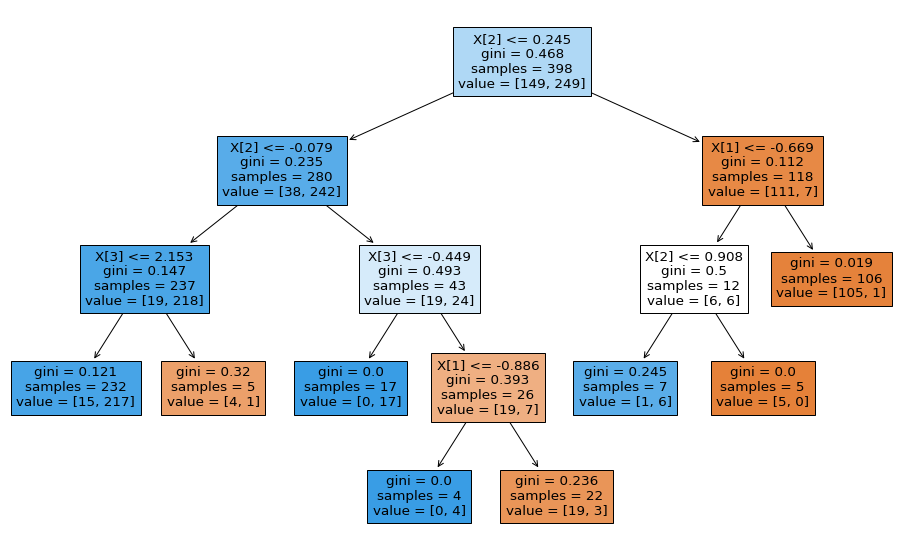

In [ ]:
# plot the tree
plt.figure(figsize=(16,10))
plot_tree(DT, filled=True)

In [ ]:
# Bootstrap Aggregating or Bagging

# Fine-tune the model by GridsearchCV method

# parameters and possible values
param_grid3 = ({
    'n_estimators': [50, 100, 200, 500],  # The number of base estimators in the ensemble
    'bootstrap' : [True, False]  # Whether samples are drawn with replacement
})

# Gridsearch model on Bagging Classifier using DT
BagGrid = GridSearchCV(estimator=BaggingClassifier(DT), param_grid=param_grid3, cv=8, n_jobs=-1)
BagGrid.fit(X_train_std, y_train)

# Best parameters
print(BagGrid.best_params_)

# best score
print(BagGrid.best_score_)

{'bootstrap': True, 'n_estimators': 50}
0.9146938775510204


In [ ]:
bag = BaggingClassifier(DT,
                        n_estimators=BagGrid.best_params_['n_estimators'],
                        bootstrap=BagGrid.best_params_['bootstrap'])
bag.fit(X_train_std, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=4,
                                                        max_features=None,
                                                        max_leaf_nodes=8,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
      

In [ ]:
# train loss and test loss
print('test loss: ', accuracy_score(y_test, bag.predict(X_test_std)))
print('train loss: ', accuracy_score(y_train, bag.predict(X_train_std)))

test loss:  0.9239766081871345
train loss:  0.9547738693467337


In [ ]:
# The train and test set accuracy are quite comparable.

In [ ]:
# Random Forest

# Fine-tune the model by GridsearchCV method

# parameters and possible values
param_grid4 = ({
    'n_estimators': np.arange(50,201, 50),
    'max_depth': [2, 3, 4],
    'min_samples_split' : [2, 3, 4],
    'min_samples_split' : range(2, 9)
})

# Gridsearch model on Random Forest Classifier
RFGrid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid4, cv=8, n_jobs=-1)
RFGrid.fit(X_train_std, y_train)

# Best parameters
print(RFGrid.best_params_)

# best score
print(RFGrid.best_score_)

{'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 200}
0.9222959183673469


In [ ]:
RF = RandomForestClassifier(n_estimators=RFGrid.best_params_['n_estimators'],
                            max_depth=RFGrid.best_params_['max_depth'],
                            min_samples_split=RFGrid.best_params_['min_samples_split'])
RF.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# train loss and test loss
print('test loss: ', accuracy_score(y_test, RF.predict(X_test_std)))
print('train loss: ', accuracy_score(y_train, RF.predict(X_train_std)))

test loss:  0.935672514619883
train loss:  0.9547738693467337


In [ ]:
# The train and test set accuracy are quite comparable.

In [ ]:
# XGBoost

# Fine-tune the model by GridsearchCV method

# parameters and possible values
param_grid5 = ({
    'max_depth' : [2, 3, 4],  # the maximum depth of a tree to grow during any boosting round
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],  # percentage of features to be randomly samples for each tree
    'learning_rate': [0.01, 0.1, 0.2],  # step size shrinkage used to prevent overfitting
    'n_estimators' : [50, 100, 150],
    'subsample' : [0.6, 0.8]  # percentage of samples used per tree
})

# Gridsearch model on Decision Tree Classifier
XGBGrid = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid5, cv=8, n_jobs=-1)
XGBGrid.fit(X_train_std, y_train)

# Best parameters
print(XGBGrid.best_params_)

# best score
print(XGBGrid.best_score_)

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
0.9398469387755102


In [ ]:
xgbc = XGBClassifier(colsample_bytree = XGBGrid.best_params_['colsample_bytree'],
                     learning_rate = XGBGrid.best_params_['learning_rate'],
                     max_depth = XGBGrid.best_params_['max_depth'],
                     n_estimators = XGBGrid.best_params_['n_estimators'],
                     subsample = XGBGrid.best_params_['subsample'])
xgbc.fit(X_train_std, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
# train loss and test loss
print('test loss: ', accuracy_score(y_test, xgbc.predict(X_test_std)))
print('train loss: ', accuracy_score(y_train, xgbc.predict(X_train_std)))

test loss:  0.9181286549707602
train loss:  0.9673366834170855


In [ ]:
# The train and test set accuracy are quite comparable

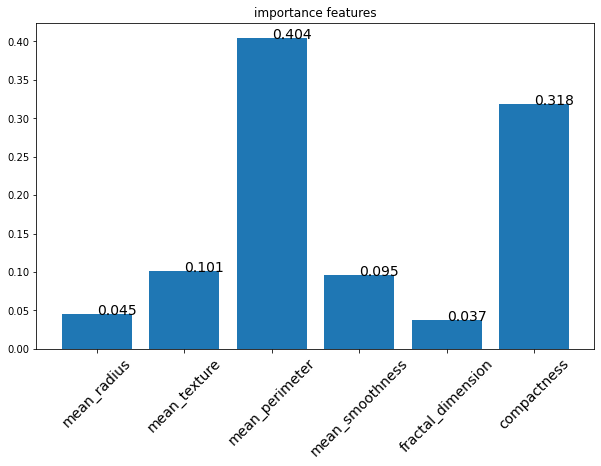

In [ ]:
# importance features in XGBoost model
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(X_train.columns, xgbc.feature_importances_)
plt.title('importance features')
plt.xticks(rotation=45, fontsize=14)
for index, value in enumerate(xgbc.feature_importances_):
  plt.text(index, value, str(round(value, 3)), fontsize=14)

In [ ]:
# Multi-Layer Perceptron

# Fine-tune the model by the GridsearchCV method

# define a two-layer Network by Keras
def create_network(optimizer):
    
    # Network body
    Network = models.Sequential()
    Network.add(layers.Dense(units=250, activation='tanh', input_shape=(X_train_std.shape[1],)))
    Network.add(layers.Dropout(0.5))  # Dropout layer
    Network.add(layers.Dense(units=250, activation='relu',))
    Network.add(layers.Dropout(0.5))  # Dropout layer
    Network.add(layers.Dense(units=1 , activation='sigmoid'))  # output layer
    Network.compile(optimizer = optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    return Network

# wrapping the model with the KerasClassifier
ANN = KerasClassifier(build_fn = create_network)

# parameters and possible values
param_grid6 = [{
    'epochs' : [8, 10, 12, 15],
    'optimizer' : ['rmsprop','adam', 'adamax', 'nadam'],
    'batch_size' : [100, 150, 200],
}]

# Gridsearch model on MLP Classifier
MLPKGrid = GridSearchCV(estimator = ANN, param_grid = param_grid6, cv=8, n_jobs=-1)
MLPKGrid.fit(X_train_std, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/10
3/3 [==============================] - 1s 7ms/step - loss: 0.5461 - accuracy: 0.7320
Epoch 2/10
3/3 [==============================] - 0s 6ms/step - loss: 0.2792 - accuracy: 0.9227
Epoch 3/10
3/3 [==============================] - 0s 6ms/step - loss: 0.2176 - accuracy: 0.9348
Epoch 4/10
3/3 [==============================] - 0s 6ms/step - loss: 0.1859 - accuracy: 0.9415
Epoch 5/10
3/3 [==============================] - 0s 6ms/step - loss: 0.1749 - accuracy: 0.9444
Epoch 6/10
3/3 [==============================] - 0s 5ms/step - loss: 0.1930 - accuracy: 0.9424
Epoch 7/10
3/3 [==============================] - 0s 6ms/step - loss: 0.1780 - accuracy: 0.9378
Epoch 8/10
3/3 [==============================] - 0s 6ms/step - loss: 0.1733 - accuracy: 0.9353
Epoch 9/10
3/3 [==============================] - 0s 6ms/step - loss: 0.1499 - accuracy: 0.9540
Epoch 10/10
3/3 [==============================] - 0s 6ms/step - loss: 0.1620 - accuracy: 0.9348


GridSearchCV(cv=8, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f05f424c908>,
             iid='deprecated', n_jobs=-1,
             param_grid=[{'batch_size': [100, 150, 200],
                          'epochs': [8, 10, 12, 15],
                          'optimizer': ['rmsprop', 'adam', 'adamax', 'nadam']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print("The best accuracy score: %f\nusing %s" % (MLPKGrid.best_score_, MLPKGrid.best_params_))

The best accuracy score: 0.942296
using {'batch_size': 150, 'epochs': 10, 'optimizer': 'rmsprop'}


In [ ]:
# Define a two-layer network using fine-tune hyperparameters
Network = models.Sequential()
Network.add(layers.Dense(units=250, activation='relu', input_shape=(X_train_std.shape[1],)))
Network.add(layers.Dropout(0.5))  # Dropout layer
Network.add(layers.Dense(units=250, activation='relu'))
Network.add(layers.Dropout(0.5))  # Dropout layer
Network.add(layers.Dense(units=1 , activation='sigmoid'))
Network.compile(optimizer = MLPKGrid.best_params_['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])
Network.fit(X_train_std, y_train, batch_size=MLPKGrid.best_params_['batch_size'], epochs=MLPKGrid.best_params_['epochs'])

mlp_k = Network.history.history['accuracy'][MLPKGrid.best_params_['epochs']-1]
print(f'\nAccuracy score on the train set: {round(mlp_k, 4)}')

Epoch 1/10
3/3 [==============================] - 1s 9ms/step - loss: 0.5855 - accuracy: 0.7515
Epoch 2/10
3/3 [==============================] - 0s 8ms/step - loss: 0.3578 - accuracy: 0.9156
Epoch 3/10
3/3 [==============================] - 0s 8ms/step - loss: 0.2759 - accuracy: 0.9119
Epoch 4/10
3/3 [==============================] - 0s 7ms/step - loss: 0.2170 - accuracy: 0.9377
Epoch 5/10
3/3 [==============================] - 0s 8ms/step - loss: 0.2090 - accuracy: 0.9348
Epoch 6/10
3/3 [==============================] - 0s 7ms/step - loss: 0.1903 - accuracy: 0.9453
Epoch 7/10
3/3 [==============================] - 0s 7ms/step - loss: 0.1656 - accuracy: 0.9448
Epoch 8/10
3/3 [==============================] - 0s 9ms/step - loss: 0.1668 - accuracy: 0.9411
Epoch 9/10
3/3 [==============================] - 0s 9ms/step - loss: 0.1663 - accuracy: 0.9465
Epoch 10/10
3/3 [==============================] - 0s 6ms/step - loss: 0.1781 - accuracy: 0.9328

Accuracy score on the train set: 0.937

In [ ]:
Network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 250)               1750      
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 251       
Total params: 64,751
Trainable params: 64,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model Evaluation

def model_performance (y_test, y_pred):
    #confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    class_names = y_test.unique()  # class names
    
    # plot the matrix
    Matrix_df = pd.DataFrame(matrix, index=class_names, columns=class_names)
    sns.heatmap(Matrix_df, annot=True, cbar=None, cmap='Blues', linewidths=5)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    
    # First, get tp, tn, fp, fn
    tp = matrix[1,1]
    tn = matrix[0,0]
    fp = matrix[1,0]
    fn = matrix[0,1]
    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    precision = tp / (tp + fp)
    
    # Recall
    recall = tp / (tp + fn)    
    
    # Sensitivity
    sensitivity = recall
    
    # Specificity
    specificity = tn / (fp + tn)
    
    # Print results
    print("Accuracy:",round(acc,4),"\nRecall:",round(recall,4),"\nPrecision:",round(precision,4),
          "\nSensitivity:",round(sensitivity,4),"\nSpecificity:",round(specificity,4))

In [ ]:
def area_under_roc (y_test, y_test_prob):

    # ROC for all-variable classifier
    newfpr, newtpr, new_ = roc_curve(y_test, y_test_prob[:,1], pos_label=1)
    ax=sns.lineplot(newfpr,newtpr)
    plt.title('ROC curve for all-variable classifier')

    # AUROC
    print("The area under the ROC curve: ", round(auc(newfpr,newtpr), 4))

tp: 100 tn: 56 fp: 8 fn: 7
Accuracy: 0.9123 
Recall: 0.9346 
Precision: 0.9259 
Sensitivity: 0.9346 
Specificity: 0.875


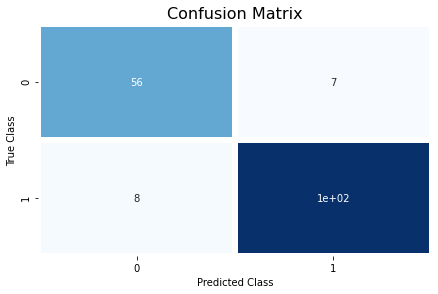

In [ ]:
# Logistic Regression Evaluation
model_performance(y_test, logreg.predict(X_test_std))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


The area under the ROC curve:  0.9849


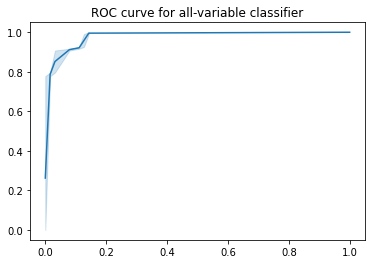

In [ ]:
# All variable classifier using the test data
area_under_roc(y_test, logreg.predict_proba(X_test_std))

tp: 98 tn: 55 fp: 10 fn: 8
Accuracy: 0.8947 
Recall: 0.9245 
Precision: 0.9074 
Sensitivity: 0.9245 
Specificity: 0.8462


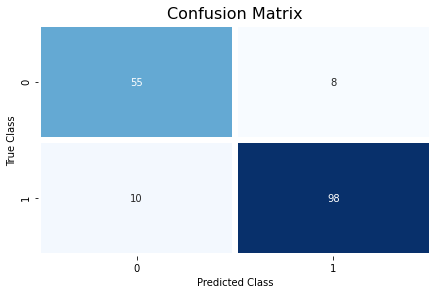

In [ ]:
# Decision Tree Evaluation
model_performance(y_test, DT.predict(X_test_std))

The area under the ROC curve:  0.9145


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


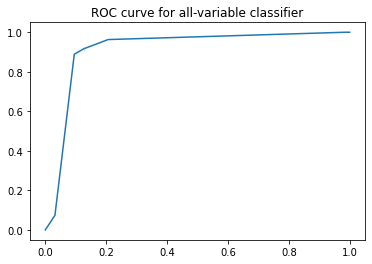

In [ ]:
# All variable classifier using the test data
area_under_roc(y_test, DT.predict_proba(X_test_std))

tp: 102 tn: 56 fp: 6 fn: 7
Accuracy: 0.924 
Recall: 0.9358 
Precision: 0.9444 
Sensitivity: 0.9358 
Specificity: 0.9032


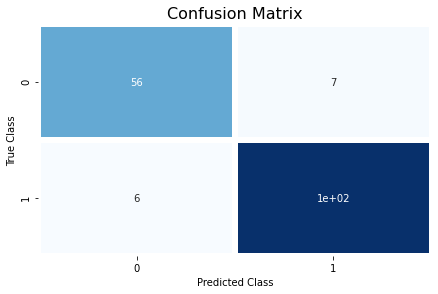

In [ ]:
# Bagging Model Evaluation
model_performance(y_test, bag.predict(X_test_std))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


The area under the ROC curve:  0.9785


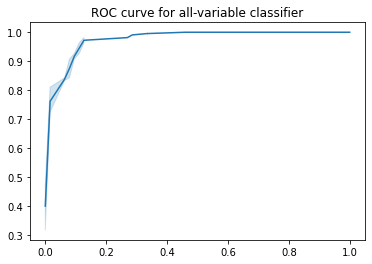

In [ ]:
area_under_roc(y_test, bag.predict_proba(X_test_std))

tp: 103 tn: 57 fp: 5 fn: 6
Accuracy: 0.9357 
Recall: 0.945 
Precision: 0.9537 
Sensitivity: 0.945 
Specificity: 0.9194


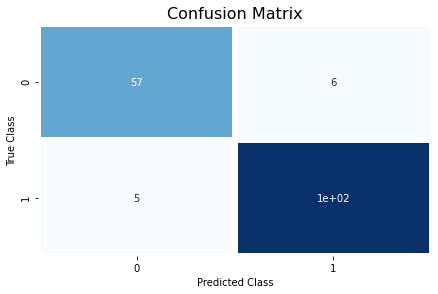

In [ ]:
# Random Forest Evaluation
model_performance(y_test, RF.predict(X_test_std))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


The area under the ROC curve:  0.9807


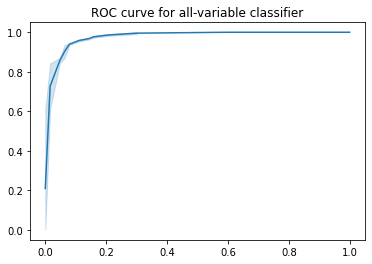

In [ ]:
area_under_roc(y_test, RF.predict_proba(X_test_std))

tp: 101 tn: 56 fp: 7 fn: 7
Accuracy: 0.9181 
Recall: 0.9352 
Precision: 0.9352 
Sensitivity: 0.9352 
Specificity: 0.8889


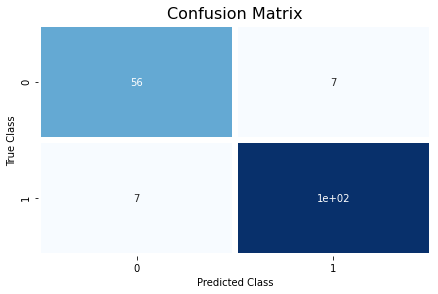

In [ ]:
# XGBoost Evaluation
model_performance(y_test, xgbc.predict(X_test_std))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


The area under the ROC curve:  0.9828


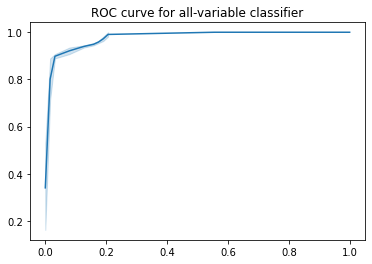

In [ ]:
area_under_roc(y_test, xgbc.predict_proba(X_test_std))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


tp: 101 tn: 58 fp: 7 fn: 5
Accuracy: 0.9298 
Recall: 0.9528 
Precision: 0.9352 
Sensitivity: 0.9528 
Specificity: 0.8923


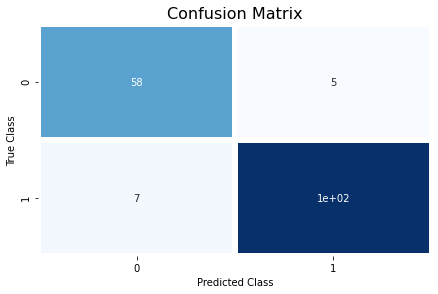

In [ ]:
# MLP Evaluation
model_performance(y_test, Network.predict_classes(X_test_std))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


The area under the ROC curve:  0.9852


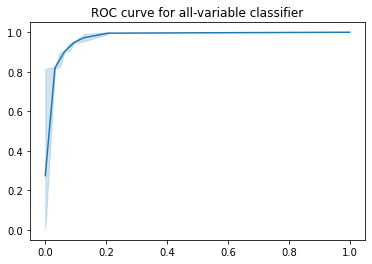

In [ ]:
# a list that contains the probabilities of classes
pred_list = np.zeros((X_test_std.shape[0], 2))
for i in range(X_test_std.shape[0]):
    pred_list[i][0] = 1-Network.predict(X_test_std)[i]
    pred_list[i][1] = Network.predict(X_test_std)[i]

# The AUC for MLP
area_under_roc(y_test, pred_list)

In [ ]:
# In terms of accuracy, Random Forest and MLP have done the best performance.
# In addition, MLP has had the best performance among all models, in terms of AUC. Logistic Regression was ranked as the second one, just a head  of XGBoost. This implies that these two models are good at seperating positive classes from negative classes which is very important given the nature of our dataset and its application.